In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import statistics
import kmax as kx
import utility as util
from hierarchy import *
from scipy.optimize import fsolve
from IPython.core.debugger import set_trace
import scipy.stats as stats
import pylab
import math

In [2]:
num_samples = 10000
LAM = 0.7

### Function Definitions

In [3]:
# Calculate the length of the path passing 
# through `node` in `path_cover`
def path_seg_length(tree, path_cover, node):
    if len(path_cover) == 0:
        return 0
    
    path_subgraph = tree.edge_subgraph(path_cover)
    if node not in path_subgraph:
        return 0

    # node_connected_component returns a list of nodes, so we subtract 1 to get the number of edges
    return len(nx.node_connected_component(path_subgraph, node)) - 1

def all_path_seg_lengths(tree):
    hist_data = {}
    component_root = 0
    path_cover,_,_,_ = util.path_cover(tree, root=component_root)
    path_subgraph = tree.edge_subgraph(path_cover)
    for path in nx.connected_components(path_subgraph):
        seg_len = len(path) - 1
        if seg_len not in hist_data:
            hist_data[seg_len] = 1
        else:
            hist_data[seg_len] += 1
    return hist_data

def root_seg_length(tree):
    path_cover,_,_,_ = util.path_cover(tree, root=0)
    return path_seg_length(tree, path_cover, 0)

def root_seg_length_z(tree):
    path_cover,_,_,z_root = util.path_cover(tree, root=0)
    return path_seg_length(tree, path_cover, 0), z_root

In [4]:
def run_samples(graph_gen, sup_crit=False):
    root_seg_lengths_z0 = []
    root_seg_lengths_z1 = []
    while len(root_seg_lengths_z0) + len(root_seg_lengths_z1) < num_samples:
        sample_tree = graph_gen()
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        if sup_crit and nx.diameter(sample_tree) < 10:
            continue
    
        seg_len, z_root = root_seg_length_z(sample_tree)
        if z_root == 0:
            root_seg_lengths_z0.append(seg_len)
        else:
            root_seg_lengths_z1.append(seg_len)
    return root_seg_lengths_z0, root_seg_lengths_z1

#### Theoretical value approximations

In [5]:
def solve_p(lam):
    func = lambda p: [p[0] * np.exp(lam*p[0]) - (1 + lam * p[0])]
    return float(fsolve(func, 1)[0])

def solve_r(lam):
    p = solve_p(lam)
    return lam * np.exp(-lam * p)

def compute_L(k, lam=LAM):
    p = solve_p(lam)
    r = solve_r(lam)
    return (1-r) * r**(k-2) * (p * r**2 + (1-p) * (1-r) * max(0,(k-1)))

def compute_L_one(k, lam=LAM):
    p = solve_p(lam)
    r = lam * np.exp(-lam * p)
    return p * (1-r) * math.pow(r, k)

def compute_L_zero(k, lam=LAM):
    p = solve_p(lam)
    r = lam * np.exp(-lam * p)
    return (1-p) * math.pow(1-r, 2) * math.pow(r, k - 2) * max(0, (k-1))

In [27]:
def draw_tree(tree, layout, draw_path=True):
    rooted_tree = nx.bfs_tree(tree, 0)
    
    #nx.draw_networkx_nodes(tree, pos=layout, node_size=29)
    nx.draw_networkx_labels(tree, pos=layout, font_size=10, font_color="tab:blue")
    
    if draw_path:
        path_cover,_,X,_=util.path_cover(tree)
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=path_cover, edge_color="tab:red", arrows=True)
        
        other_edges = [(u,v) for u,v in rooted_tree.edges() if (u,v) not in path_cover and (v,u) not in path_cover]
        nx.draw_networkx_edges(rooted_tree, pos=layout, edgelist=other_edges)
    else:
        nx.draw_networkx_edges(rooted_tree, pos=layout)

def generate_histogram(dataset, func = compute_L, bins = np.arange(0,100,1), title=None):
    theoretical_seg_lengths = [func(b) * num_samples for b in bins]
    plt.figure(figsize=(6,6))
    plt.bar(bins, theoretical_seg_lengths, color='red', width=1)
    plt.hist(dataset, bins=bins, edgecolor = 'black', linewidth=1.2, color = 'lightblue', alpha=0.5)
    if title:
        plt.title(title, fontfamily=['Serif'])
    else:
        plt.title(f"Path segment length\n(GWBP, $\lambda={LAM}$, {num_samples} samples)", fontfamily=['Serif'])
    plt.xticks(bins)
    plt.xlabel("Path length in optimal path cover", fontfamily=['Serif'], fontsize=12)
    plt.ylabel("Occurences", fontfamily=['Serif'], fontsize=12)
    plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
C:\Users\jgodu\AppData\Local\Temp\ipykernel_19828\621109162.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Path segment length\n(GWBP, $\lambda={LAM}$, {num_samples} samples)", fontfamily=['Serif'])


### Single Sample

In [7]:
#sample_tree = nx.fast_gnp_random_graph(n, lam/n)
sample_tree = nx.random_labeled_tree(30)
for u,v in sample_tree.edges():
    sample_tree[u][v]['weight'] = 1

seg_length_counts = all_path_seg_lengths(sample_tree)

In [8]:
seg_length_counts

{9: 1, 3: 2, 2: 3}

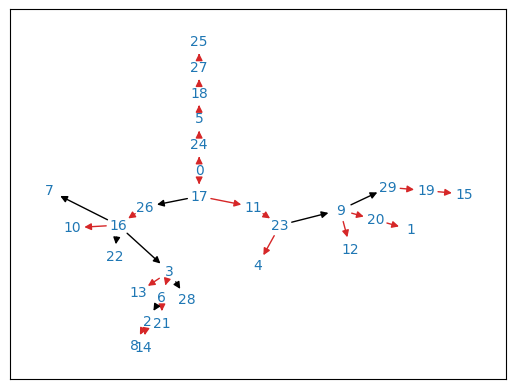

In [9]:
draw_tree(sample_tree, hierarchyc_pos(sample_tree, root=0))

# Galton-Watson Branching Process - $\text{Pois}(\lambda)$

## Subcritical case $(\lambda < 1)$

In [32]:
LAM = 0.7

### Average Segment Length

In [33]:
seg_lengths = []
for _ in range(num_samples):
    # Poisson Branching
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    for (l,c) in all_path_seg_lengths(sample_tree).items():
        for _ in range(c):
            seg_lengths.append(l)

### Root segment length

In [34]:
root_seg_lengths = []
for _ in range(num_samples):
    sample_tree = nx.Graph(GWBP(LAM, MAXLEVEL=100))
    for u,v in sample_tree.edges():
        sample_tree[u][v]['weight'] = 1

    root_seg_lengths.append(root_seg_length(sample_tree))

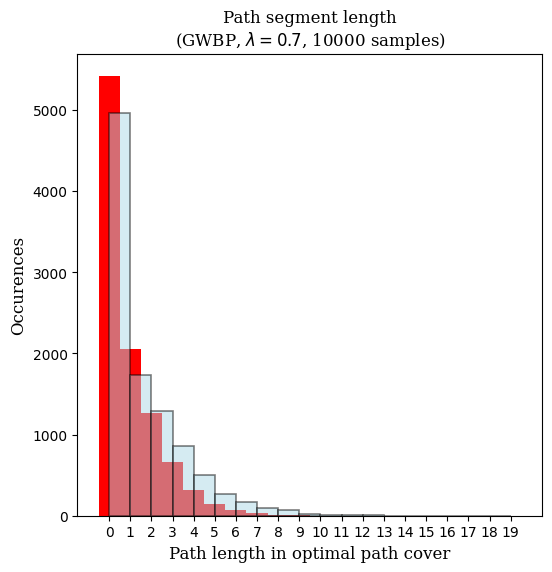

In [35]:
generate_histogram(root_seg_lengths, bins=np.arange(0,20,1))

### Root segmenth length (split by z)

Let $L$ be a random variable denoting the length of the path segment passing through the root of a GWBP tree $(\text{Pois}(\lambda))$.

Further, let $L_0$ denote the length of the root path segment $L$ conditioning on $z_{\text{root}}=0$.

Similarly, let $L_1$ denote the length of the root path segment $L$ conditioning on $z_{\text{root}}=1$.

Then we expect
$$
\begin{align*}
L_0 &\sim \text{geom}(1-r) \oplus \text{geom}(1-r), \\
L_1 &\sim \text{geom}(1-r) - 1,
\end{align*}
$$
where $r = \lambda e^{-\lambda p}$ and $p$ is the solution to the equation
$$
p = (1+\lambda p) e^{-\lambda p} = \mathbb{P}(z_{\text{root}}=1).
$$

In [36]:
func = lambda: nx.Graph(GWBP(0.7, MAXLEVEL=100))
rsl_z0, rsl_z1 = run_samples(func)
len(rsl_z1) / num_samples

0.8777

We should have $\mathbb{P}(z_{\text{root}}=1)=p$.
Let's compute a sample probability and compare:

In [37]:
print(f'p = {solve_p(0.7)}')
print(f'# z(root)=0 = {len(rsl_z0)}')
print(f'# z(root)=1 = {len(rsl_z1)}')
print(f'sample P(z(root)=1) = {len(rsl_z1) / num_samples}')

p = 0.8741606425132523
# z(root)=0 = 1223
# z(root)=1 = 8777
sample P(z(root)=1) = 0.8777


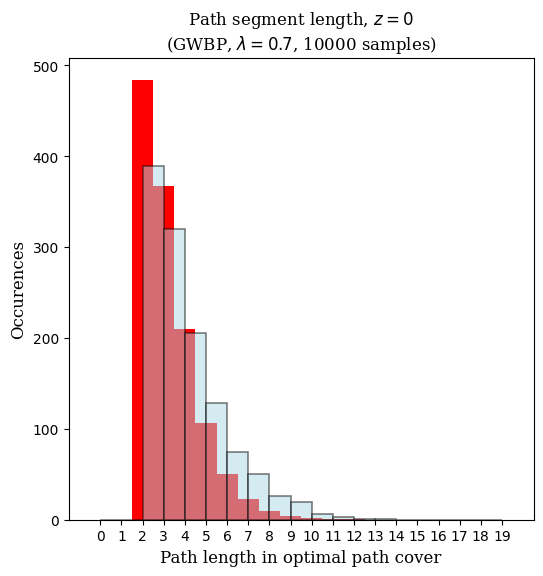

In [38]:
generate_histogram(rsl_z0, func = compute_L_zero, bins=np.arange(0,20,1),
                   title = f"Path segment length, $z=0$\n(GWBP, $\\lambda={LAM}$, {num_samples} samples)")

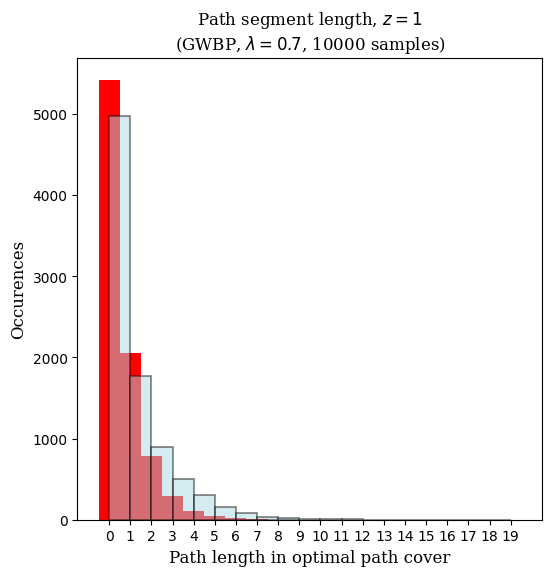

In [39]:
generate_histogram(rsl_z1, func = compute_L_one, bins=np.arange(0,20,1),
                   title = f"Path segment length, $z=1$\n(GWBP, $\\lambda={LAM}$, {num_samples} samples)")

## Supercritical case $(\lambda > 1)$
Note: we discard any trees that "go extinct" before MAXLEVEL (i.e., have level < MAXLEVEL = 10).

In [17]:
LAM = 1.5

In [18]:
solve_p(LAM)

0.7112014274154725

In [19]:
# Without discarding (matches theoretical value of p better)
func = lambda: nx.Graph(GWBP(LAM, MAXLEVEL=10))
rsl_z0, rsl_z1 = run_samples(func, sup_crit=False)
len(rsl_z1) / num_samples

0.7141

In [20]:
# With discarding
rsl_z0, rsl_z1 = run_samples(func, sup_crit=True)
rsls = rsl_z0 + rsl_z1
len(rsl_z1) / num_samples

0.5698

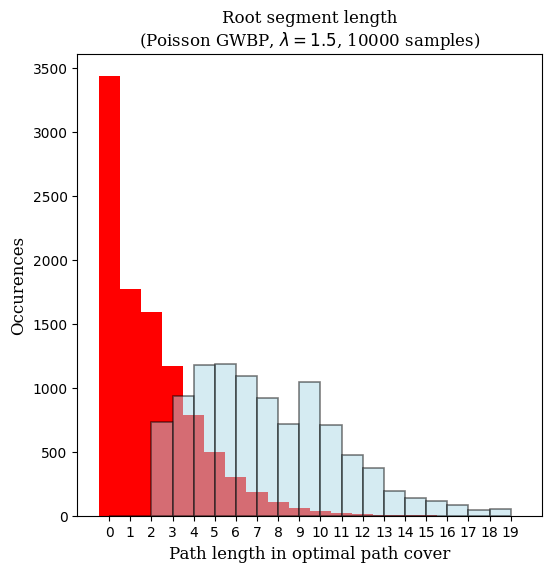

In [21]:
generate_histogram(rsls, lambda k: compute_L(k, LAM), bins=np.arange(0,20,1),
                  title=f'Root segment length\n(Poisson GWBP, $\\lambda={LAM}$, {num_samples} samples)')

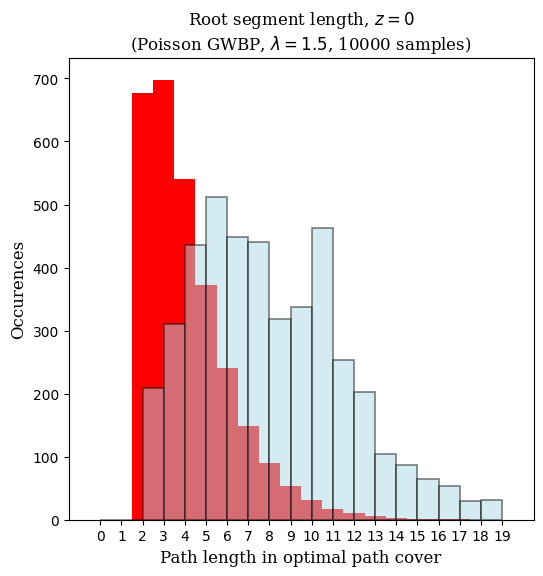

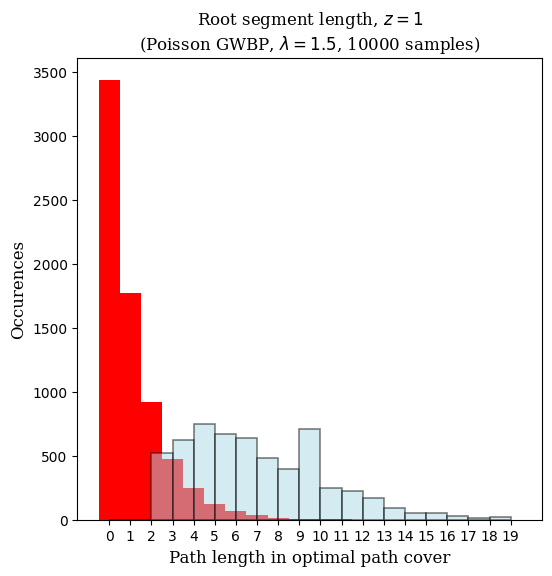

In [26]:
generate_histogram(rsl_z0, lambda k: compute_L_zero(k, LAM), bins=np.arange(0,20,1),
                   title = f"Root segment length, $z = 0$\n(Poisson GWBP, $\\lambda={LAM}$, {num_samples} samples)")
generate_histogram(rsl_z1, lambda k: compute_L_one(k, LAM), bins=np.arange(0,20,1),
                   title= f"Root segment length, $z = 1$\n(Poisson GWBP, $\\lambda={LAM}$, {num_samples} samples)")

# Galton-Watson Branching Process - $\mathcal{U}(0,1,2,3)$

In [23]:
def run_samples_uniform():
    rsls = []
    while len(rsls) < num_samples:
        unif_dist = lambda: np.random.randint(4)
        sample_tree = nx.Graph(GWBP(dist=unif_dist, MAXLEVEL=10))
        for u,v in sample_tree.edges():
            sample_tree[u][v]['weight'] = 1

        rsls.append(root_seg_length(sample_tree))
    return rsls

In [24]:
uniform_rsls = run_samples_uniform()

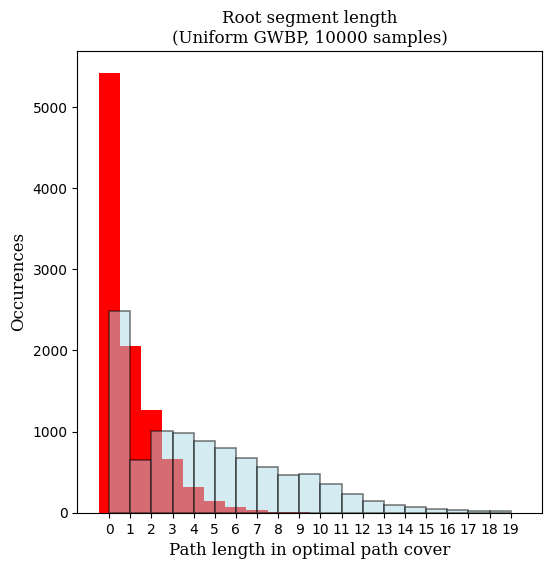

In [25]:
generate_histogram(uniform_rsls, bins=np.arange(0,20,1),
                   title=f"Root segment length\n(Uniform GWBP, {num_samples} samples)")